In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(palette='viridis', font_scale=2, font='times', style='white')

regions = ['nsw', 'sa']
y_axis_var = 'net_load'

dfs = []
for region in regions:
    df = pd.read_csv(f'../data/{region}/merged.csv')
    df.datetime = df.datetime.astype('datetime64')
    df['region'] = region
    dt = df['datetime'].dt
    df['date'] = dt.date
    df['year'] = dt.year
    df['month'] = dt.month
    df['day'] = dt.day
    df['hour'] = dt.hour
    df['minute'] = dt.minute
    df['day_of_week'] = dt.weekday.astype('str') + '-' + dt.day_name().str[:3]
    df['isoyear'] = dt.isocalendar().year
    df['week'] = dt.isocalendar().week
    df['day_of_year'] = dt.day_of_year
    df['week_of_month'] = (dt.day - 1) // 7 # day of month - 1 (0-30) // 7 (0-6=0, 7-13=1, 14-20=2, 21-27=3, 28-x=4)
    dfs.append(df)
df = pd.concat(dfs)

# extract holidays from file
holiday_df = pd.read_csv('../data/holidays2017_2024.csv', dtype='str')
holiday_df['Date'] = holiday_df['Date'].astype('datetime64[ns]')
holidays = holiday_df.loc[holiday_df['Jurisdiction'] == 'sa', ['Date', 'Holiday Name']]

merged = pd.merge(dt.floor('D'), holidays, left_on='datetime', right_on='Date', how='left')
df['holiday'] = merged['Holiday Name']

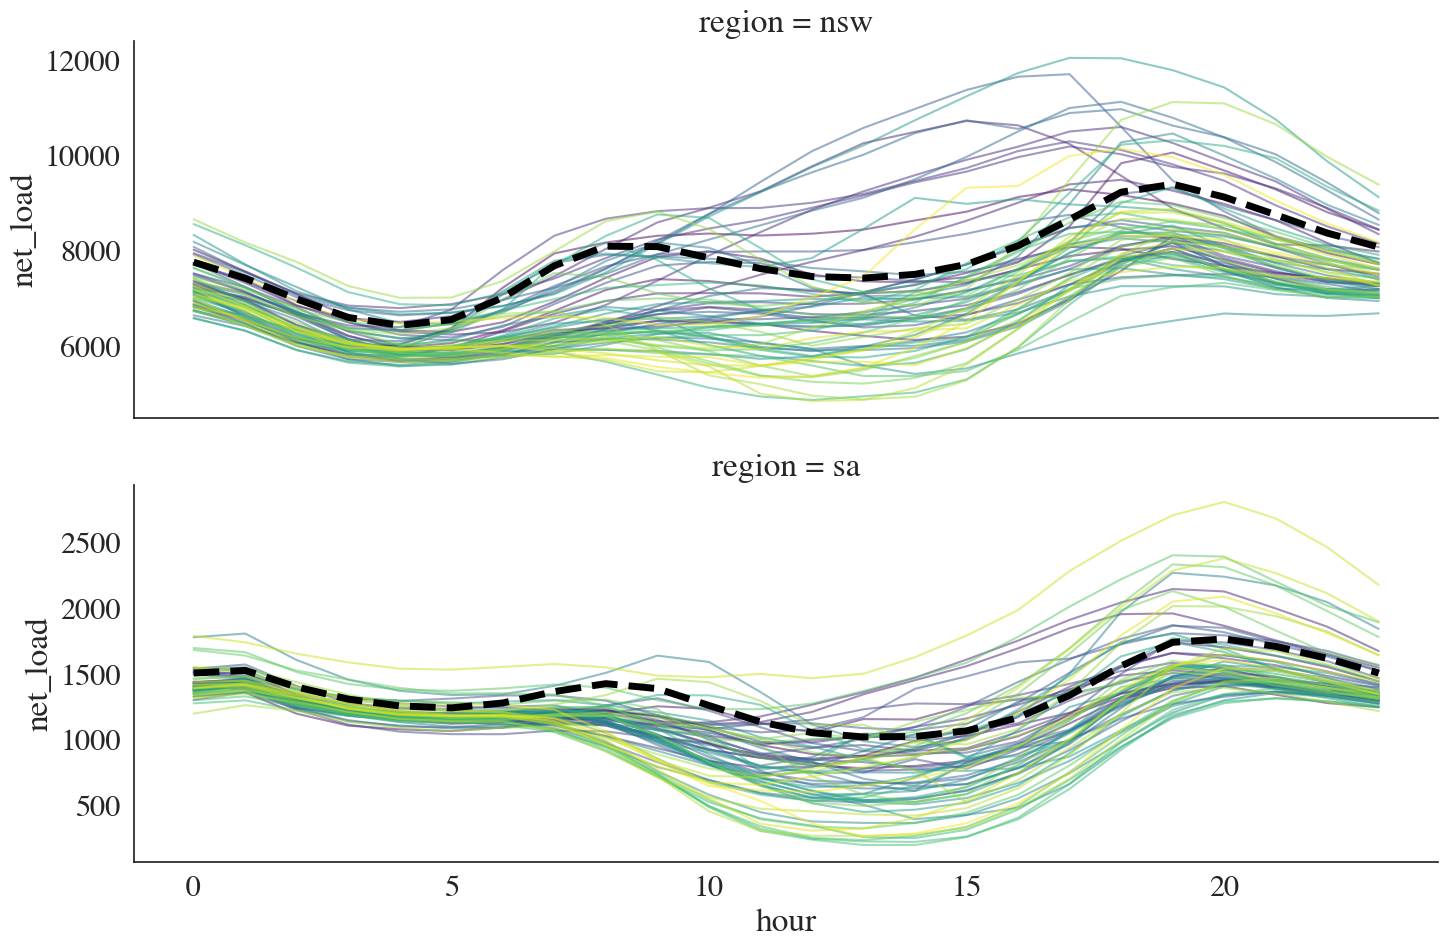

In [3]:
df_holidays = df[df['holiday'].notna()]
regional_means = df.groupby(['region', 'hour'])[['net_load']].mean().reset_index()

g = sns.relplot(df_holidays.reset_index(), x='hour', y='net_load', 
                kind='line', row='region', alpha=0.5, hue='date', 
                palette='viridis', legend=None, aspect=3, facet_kws={'sharey':False})
for ax in g.axes.flatten():
    rgn = ax.get_title().split(' = ')[1]
    ax.plot('hour', 'net_load', data=regional_means[regional_means['region'] == rgn], 
            linewidth=5, linestyle='dashed', color='black')

g.savefig('../plots/holidays_regional')

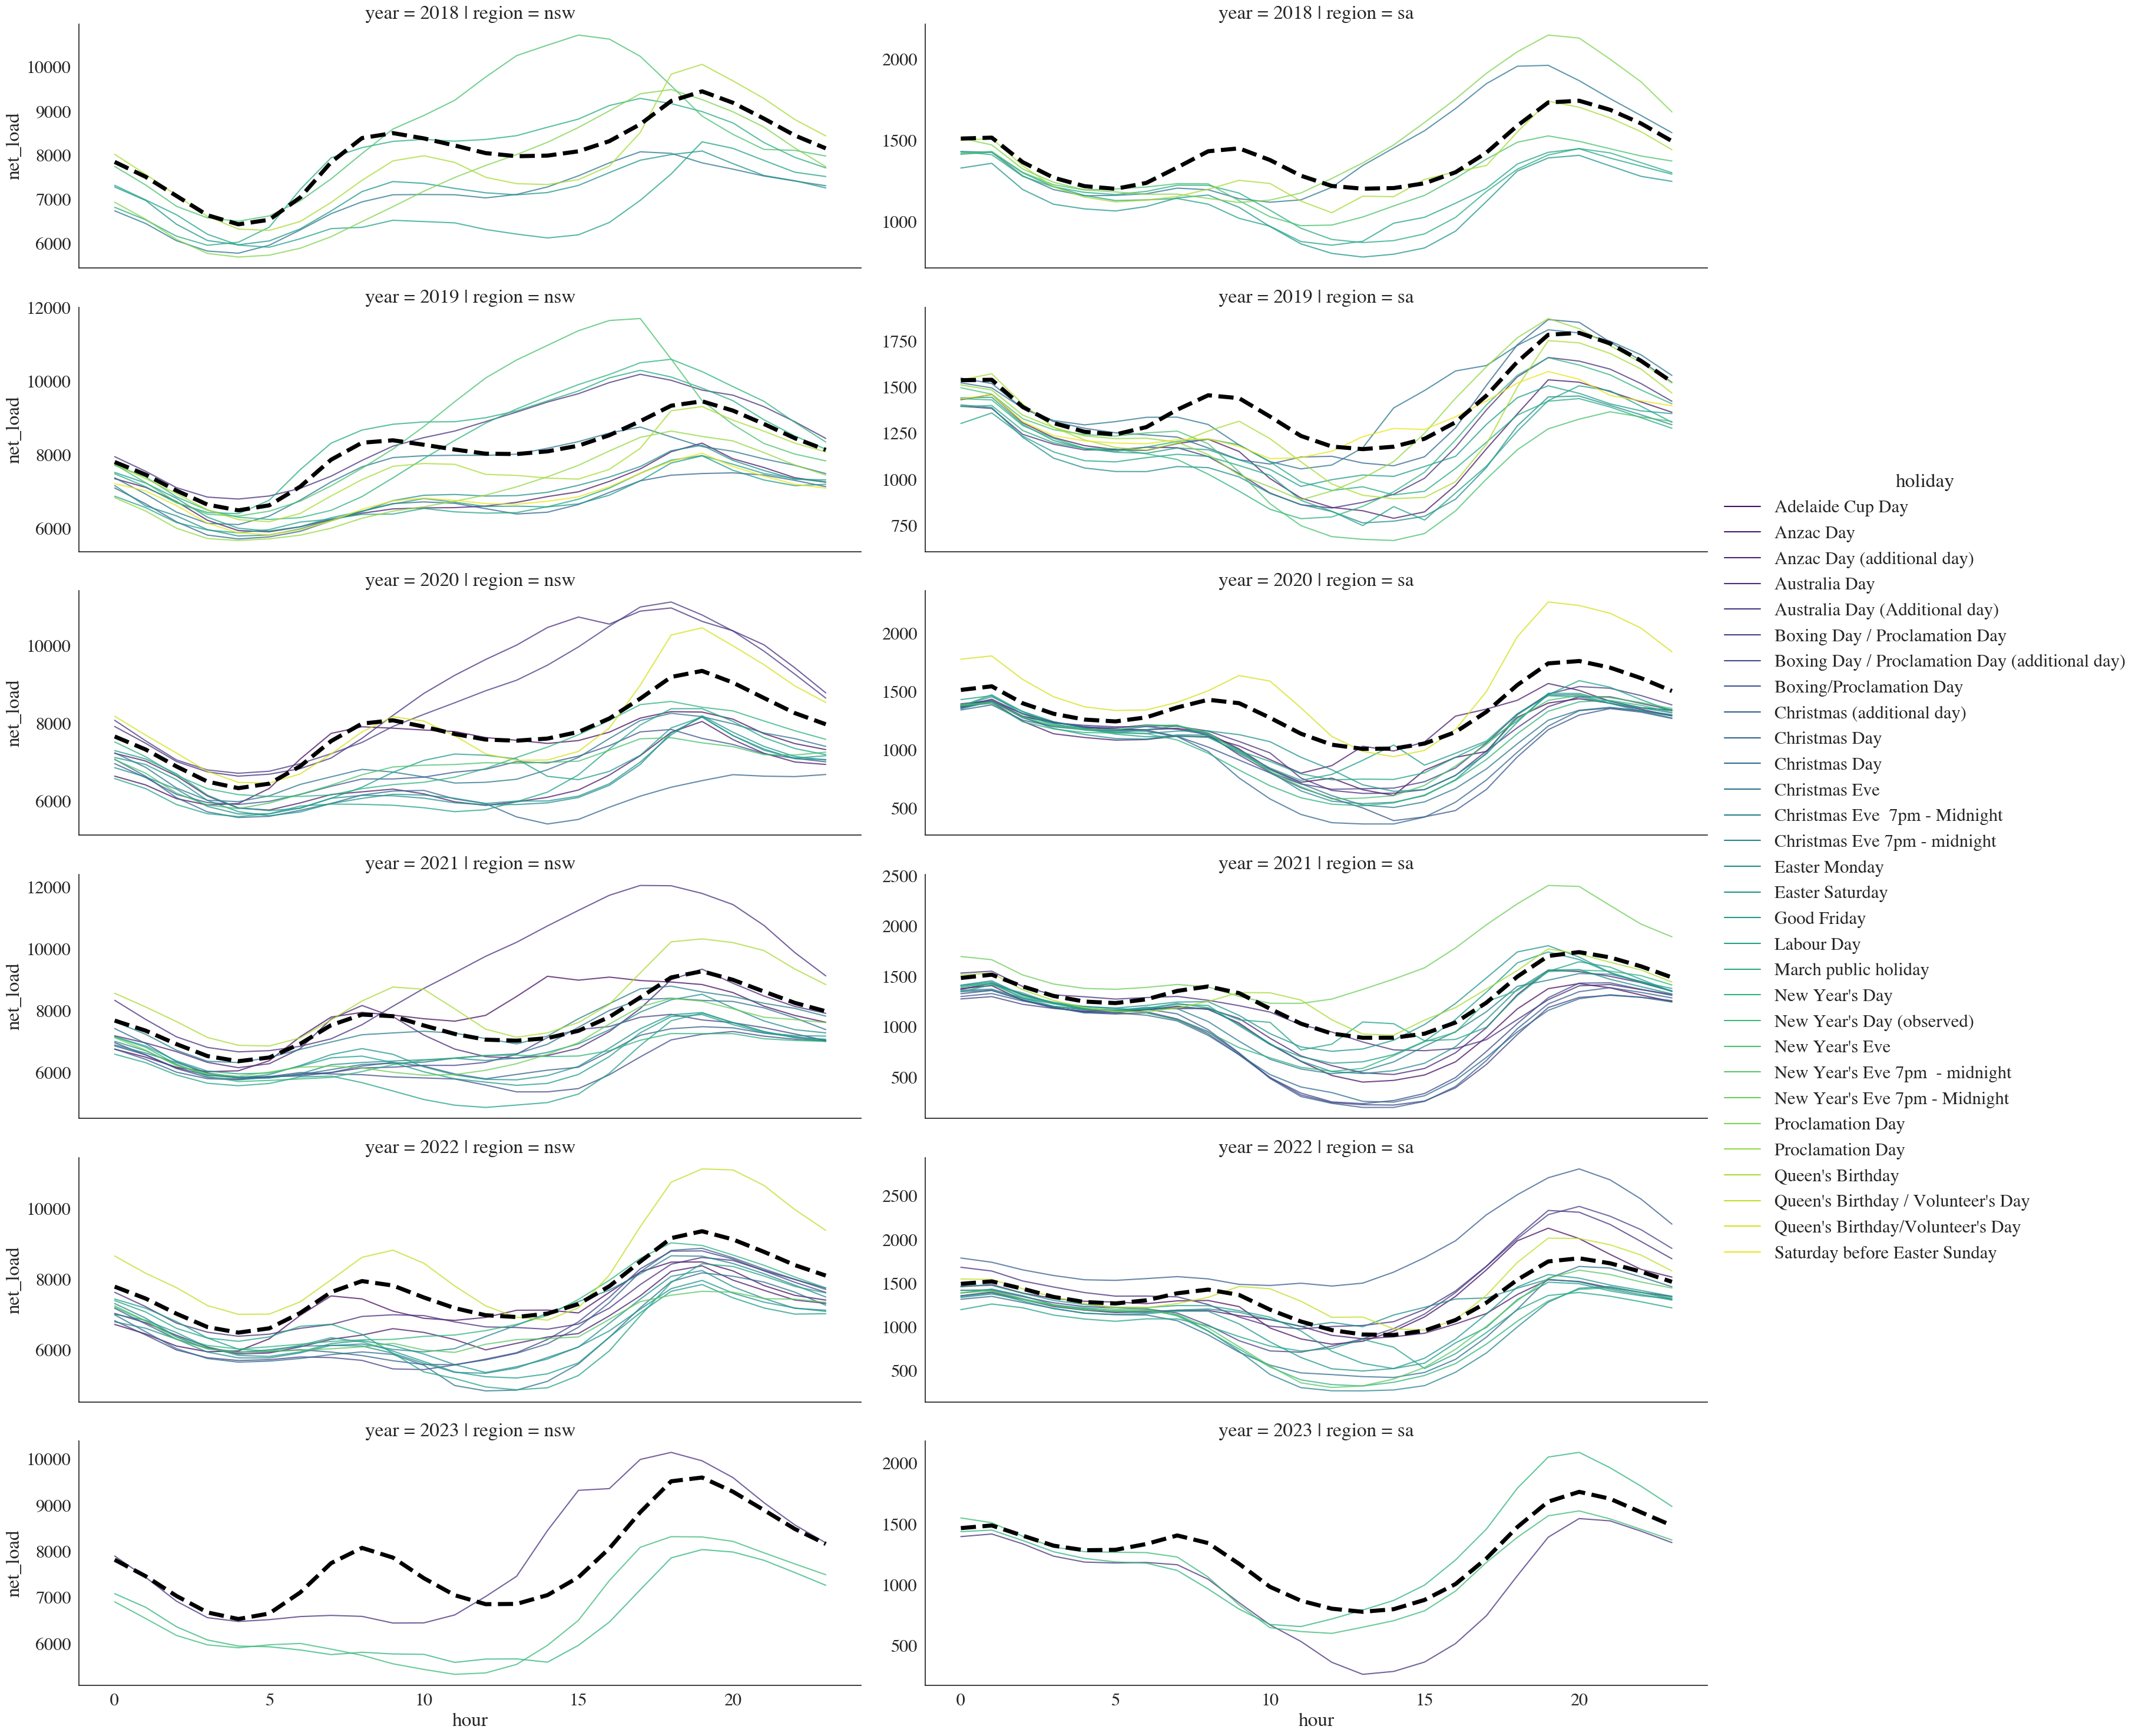

In [5]:
df_holidays = df[df['holiday'].notna()]
annual_regional_means = df.groupby(['year', 'region', 'hour'])[['net_load']].mean().reset_index()

g = sns.relplot(df_holidays.reset_index(), x='hour', y='net_load', kind='line', row='year',
                col='region', hue='holiday', hue_order=sorted(df_holidays['holiday'].unique()),
                palette='viridis', facet_kws={'sharey': False}, aspect=3, alpha=0.75)

for ax in g.axes.flatten():
    yr, rgn = [title.split(' = ')[1] for title in ax.get_title().split(' | ')]
    means = annual_regional_means[np.logical_and(
        annual_regional_means['year'] == int(yr), 
        annual_regional_means['region'] == rgn
    )]
    d = ax.plot('hour', 'net_load', data=means,
            linewidth=5, linestyle='dashed', color='black')

g.savefig('../plots/holidays_regional_annual')